# Project

In this jupyter notebook, you have to write your own detector network based on a simplified KITTI dataset for 2D object detection. We already provided an exemplary setup to the problem.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import os
import numpy as np
import cv2
from tqdm.notebook import tqdm
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage.transform
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import os
import random
import argparse
import torchvision
import torchvision.transforms as transforms
from PIL import Image

##Mount your Google Drive

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load data

In [ ]:
store_path = F"drive/MyDrive/perception project" #adapt to your file location
x_train = np.load(os.path.join(store_path, "x_train.npy"))
x_test = np.load(os.path.join(store_path, "x_test.npy"))
y_train = np.load(os.path.join(store_path, "y_train.npy"), allow_pickle=True)

## Plot example
Here, we plot an example image and the corresponding GT bounding boxes.

float32


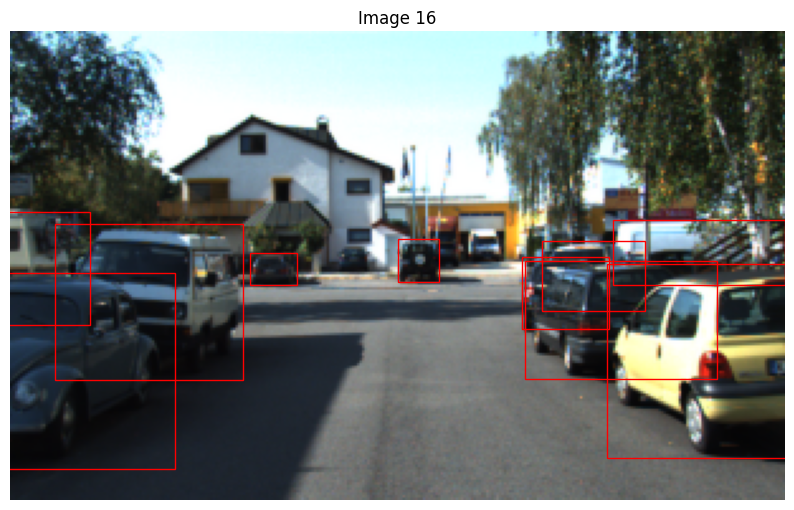

In [ ]:
# Colormap for plotted bounding boxes
cmap = {0: "r", "Pedestrian": "g", "Cyclist": "b", "Van": "yellow", "Truck": "black"}
#we deleted labels other than cars

# Get boxes & classes for specific image
im_number = 16
boxes = y_train[im_number]["boxes"]
classes = y_train[im_number]["classes"]
print(x_train.dtype)
# Plot image
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(x_train[im_number, ...])
ax.axis("off")
plt.title(f"Image {im_number}")

# Plot colored bounding boxes
for bbox, cls in zip(boxes, classes):
    try:
        cl = cmap[cls]
    except:
        cl = cmap["Misc"]
    # Add rectangle (x,y), width, heigth
    height = bbox[2] - bbox[0]
    width = bbox[3] - bbox[1]
    rect = patches.Rectangle((bbox[1], bbox[0]), width, height, linewidth=1, edgecolor=cl, facecolor="none")
    ax.add_patch(rect)

# Functions needed to calc mAP
It is not necessary to understand them in detail, but nontheless it is important to understand the mAP score.

In [ ]:
import six
import itertools
from collections import defaultdict


def voc_eval(pred_bboxes, pred_labels, pred_scores, gt_bboxes, gt_labels,
             gt_difficults=None, iou_thresh=0.5, use_07_metric=True):
    '''Wrap VOC evaluation for PyTorch.'''
    pred_bboxes = [xy2yx(b).cpu().numpy() if b.shape != (0,) else np.zeros((0, 4)) for b in pred_bboxes]
    pred_labels = [label.numpy() for label in pred_labels]
    pred_scores = [score.cpu().numpy() for score in pred_scores]
    gt_bboxes = [xy2yx(b).cpu().numpy() if b.shape != (0,) else np.zeros((0, 4)) for b in gt_bboxes]
    gt_labels = [label.numpy() for label in gt_labels]
    return eval_detection_voc(
               pred_bboxes, pred_labels, pred_scores, gt_bboxes,
               gt_labels, gt_difficults, iou_thresh, use_07_metric)

def xy2yx(boxes):
    '''Convert box (xmin,ymin,xmax,ymax) to (ymin,xmin,ymax,xmax).'''
    c0 = boxes[:,0].clone()
    c2 = boxes[:,2].clone()
    boxes[:,0] = boxes[:,1]
    boxes[:,1] = c0
    boxes[:,2] = boxes[:,3]
    boxes[:,3] = c2
    return boxes

def bbox_iou(bbox_a, bbox_b):
    '''Calculate the Intersection of Unions (IoUs) between bounding boxes.
    Args:
        bbox_a (array): An array whose shape is :math:`(N, 4)`.
            :math:`N` is the number of bounding boxes.
            The dtype should be :obj:`numpy.float32`.
        bbox_b (array): An array similar to :obj:`bbox_a`,
            whose shape is :math:`(K, 4)`.
            The dtype should be :obj:`numpy.float32`.
    Returns:
        array:
        An array whose shape is :math:`(N, K)`. \
        An element at index :math:`(n, k)` contains IoUs between \
        :math:`n` th bounding box in :obj:`bbox_a` and :math:`k` th bounding \
        box in :obj:`bbox_b`.
    '''
    # top left
    tl = np.maximum(bbox_a[:, None, :2], bbox_b[:, :2])
    # bottom right
    br = np.minimum(bbox_a[:, None, 2:], bbox_b[:, 2:])

    area_i = np.prod(br - tl, axis=2) * (tl < br).all(axis=2)
    area_a = np.prod(bbox_a[:, 2:] - bbox_a[:, :2], axis=1)
    area_b = np.prod(bbox_b[:, 2:] - bbox_b[:, :2], axis=1)
    return area_i / (area_a[:, None] + area_b - area_i)

def eval_detection_voc(
        pred_bboxes, pred_labels, pred_scores, gt_bboxes, gt_labels,
        gt_difficults=None,
        iou_thresh=0.5, use_07_metric=False):
    """Calculate average precisions based on evaluation code of PASCAL VOC.
    This function evaluates predicted bounding boxes obtained from a dataset
    which has :math:`N` images by using average precision for each class.
    The code is based on the evaluation code used in PASCAL VOC Challenge.
    Args:
        pred_bboxes (iterable of numpy.ndarray): An iterable of :math:`N`
            sets of bounding boxes.
            Its index corresponds to an index for the base dataset.
            Each element of :obj:`pred_bboxes` is a set of coordinates
            of bounding boxes. This is an array whose shape is :math:`(R, 4)`,
            where :math:`R` corresponds
            to the number of bounding boxes, which may vary among boxes.
            The second axis corresponds to
            :math:`y_{min}, x_{min}, y_{max}, x_{max}` of a bounding box.
        pred_labels (iterable of numpy.ndarray): An iterable of labels.
            Similar to :obj:`pred_bboxes`, its index corresponds to an
            index for the base dataset. Its length is :math:`N`.
        pred_scores (iterable of numpy.ndarray): An iterable of confidence
            scores for predicted bounding boxes. Similar to :obj:`pred_bboxes`,
            its index corresponds to an index for the base dataset.
            Its length is :math:`N`.
        gt_bboxes (iterable of numpy.ndarray): An iterable of ground truth
            bounding boxes
            whose length is :math:`N`. An element of :obj:`gt_bboxes` is a
            bounding box whose shape is :math:`(R, 4)`. Note that the number of
            bounding boxes in each image does not need to be same as the number
            of corresponding predicted boxes.
        gt_labels (iterable of numpy.ndarray): An iterable of ground truth
            labels which are organized similarly to :obj:`gt_bboxes`.
        gt_difficults (iterable of numpy.ndarray): An iterable of boolean
            arrays which is organized similarly to :obj:`gt_bboxes`.
            This tells whether the
            corresponding ground truth bounding box is difficult or not.
            By default, this is :obj:`None`. In that case, this function
            considers all bounding boxes to be not difficult.
        iou_thresh (float): A prediction is correct if its Intersection over
            Union with the ground truth is above this value.
        use_07_metric (bool): Whether to use PASCAL VOC 2007 evaluation metric
            for calculating average precision. The default value is
            :obj:`False`.
    Returns:
        dict:
        The keys, value-types and the description of the values are listed
        below.
        * **ap** (*numpy.ndarray*): An array of average precisions. \
            The :math:`l`-th value corresponds to the average precision \
            for class :math:`l`. If class :math:`l` does not exist in \
            either :obj:`pred_labels` or :obj:`gt_labels`, the corresponding \
            value is set to :obj:`numpy.nan`.
        * **map** (*float*): The average of Average Precisions over classes.
    """

    prec, rec = calc_detection_voc_prec_rec(
        pred_bboxes, pred_labels, pred_scores,
        gt_bboxes, gt_labels, gt_difficults,
        iou_thresh=iou_thresh)

    ap = calc_detection_voc_ap(prec, rec, use_07_metric=use_07_metric)

    return {'ap': ap, 'map': np.nanmean(ap)}


def calc_detection_voc_prec_rec(
        pred_bboxes, pred_labels, pred_scores, gt_bboxes, gt_labels,
        gt_difficults=None,
        iou_thresh=0.5):
    """Calculate precision and recall based on evaluation code of PASCAL VOC.
    This function calculates precision and recall of
    predicted bounding boxes obtained from a dataset which has :math:`N`
    images.
    The code is based on the evaluation code used in PASCAL VOC Challenge.
    Args:
        pred_bboxes (iterable of numpy.ndarray): An iterable of :math:`N`
            sets of bounding boxes.
            Its index corresponds to an index for the base dataset.
            Each element of :obj:`pred_bboxes` is a set of coordinates
            of bounding boxes. This is an array whose shape is :math:`(R, 4)`,
            where :math:`R` corresponds
            to the number of bounding boxes, which may vary among boxes.
            The second axis corresponds to
            :math:`y_{min}, x_{min}, y_{max}, x_{max}` of a bounding box.
        pred_labels (iterable of numpy.ndarray): An iterable of labels.
            Similar to :obj:`pred_bboxes`, its index corresponds to an
            index for the base dataset. Its length is :math:`N`.
        pred_scores (iterable of numpy.ndarray): An iterable of confidence
            scores for predicted bounding boxes. Similar to :obj:`pred_bboxes`,
            its index corresponds to an index for the base dataset.
            Its length is :math:`N`.
        gt_bboxes (iterable of numpy.ndarray): An iterable of ground truth
            bounding boxes
            whose length is :math:`N`. An element of :obj:`gt_bboxes` is a
            bounding box whose shape is :math:`(R, 4)`. Note that the number of
            bounding boxes in each image does not need to be same as the number
            of corresponding predicted boxes.
        gt_labels (iterable of numpy.ndarray): An iterable of ground truth
            labels which are organized similarly to :obj:`gt_bboxes`.
        gt_difficults (iterable of numpy.ndarray): An iterable of boolean
            arrays which is organized similarly to :obj:`gt_bboxes`.
            This tells whether the
            corresponding ground truth bounding box is difficult or not.
            By default, this is :obj:`None`. In that case, this function
            considers all bounding boxes to be not difficult.
        iou_thresh (float): A prediction is correct if its Intersection over
            Union with the ground truth is above this value..
    Returns:
        tuple of two lists:
        This function returns two lists: :obj:`prec` and :obj:`rec`.
        * :obj:`prec`: A list of arrays. :obj:`prec[l]` is precision \
            for class :math:`l`. If class :math:`l` does not exist in \
            either :obj:`pred_labels` or :obj:`gt_labels`, :obj:`prec[l]` is \
            set to :obj:`None`.
        * :obj:`rec`: A list of arrays. :obj:`rec[l]` is recall \
            for class :math:`l`. If class :math:`l` that is not marked as \
            difficult does not exist in \
            :obj:`gt_labels`, :obj:`rec[l]` is \
            set to :obj:`None`.
    """

    pred_bboxes = iter(pred_bboxes)
    pred_labels = iter(pred_labels)
    pred_scores = iter(pred_scores)
    gt_bboxes = iter(gt_bboxes)
    gt_labels = iter(gt_labels)
    if gt_difficults is None:
        gt_difficults = itertools.repeat(None)
    else:
        gt_difficults = iter(gt_difficults)

    n_pos = defaultdict(int)
    score = defaultdict(list)
    match = defaultdict(list)

    for pred_bbox, pred_label, pred_score, gt_bbox, gt_label, gt_difficult in \
        six.moves.zip(
            pred_bboxes, pred_labels, pred_scores,
            gt_bboxes, gt_labels, gt_difficults):

        if gt_difficult is None:
            gt_difficult = np.zeros(gt_bbox.shape[0], dtype=bool)

        for l in np.unique(np.concatenate((pred_label, gt_label)).astype(int)):
            pred_mask_l = pred_label == l
            pred_bbox_l = pred_bbox[pred_mask_l]
            pred_score_l = pred_score[pred_mask_l]
            # sort by score
            order = pred_score_l.argsort()[::-1]
            pred_bbox_l = pred_bbox_l[order]
            pred_score_l = pred_score_l[order]

            gt_mask_l = gt_label == l
            gt_bbox_l = gt_bbox[gt_mask_l]
            gt_difficult_l = gt_difficult[gt_mask_l]

            n_pos[l] += np.logical_not(gt_difficult_l).sum()
            score[l].extend(pred_score_l)

            if len(pred_bbox_l) == 0:
                continue
            if len(gt_bbox_l) == 0:
                match[l].extend((0,) * pred_bbox_l.shape[0])
                continue

            # VOC evaluation follows integer typed bounding boxes.
            pred_bbox_l = pred_bbox_l.copy()
            pred_bbox_l[:, 2:] += 1
            gt_bbox_l = gt_bbox_l.copy()
            gt_bbox_l[:, 2:] += 1

            iou = bbox_iou(pred_bbox_l, gt_bbox_l)
            gt_index = iou.argmax(axis=1)
            # set -1 if there is no matching ground truth
            gt_index[iou.max(axis=1) < iou_thresh] = -1
            del iou

            selec = np.zeros(gt_bbox_l.shape[0], dtype=bool)
            for gt_idx in gt_index:
                if gt_idx >= 0:
                    if gt_difficult_l[gt_idx]:
                        match[l].append(-1)
                    else:
                        if not selec[gt_idx]:
                            match[l].append(1)
                        else:
                            match[l].append(0)
                    selec[gt_idx] = True
                else:
                    match[l].append(0)

    for iter_ in (
            pred_bboxes, pred_labels, pred_scores,
            gt_bboxes, gt_labels, gt_difficults):
        if next(iter_, None) is not None:
            raise ValueError('Length of input iterables need to be same.')

    n_fg_class = max(n_pos.keys()) + 1
    prec = [None] * n_fg_class
    rec = [None] * n_fg_class

    for l in n_pos.keys():
        score_l = np.array(score[l])
        match_l = np.array(match[l], dtype=np.int8)

        order = score_l.argsort()[::-1]
        match_l = match_l[order]

        tp = np.cumsum(match_l == 1)
        fp = np.cumsum(match_l == 0)

        # If an element of fp + tp is 0,
        # the corresponding element of prec[l] is nan.
        prec[l] = tp / (fp + tp)
        # If n_pos[l] is 0, rec[l] is None.
        if n_pos[l] > 0:
            rec[l] = tp / n_pos[l]

    return prec, rec


def calc_detection_voc_ap(prec, rec, use_07_metric=False):
    """Calculate average precisions based on evaluation code of PASCAL VOC.
    This function calculates average precisions
    from given precisions and recalls.
    The code is based on the evaluation code used in PASCAL VOC Challenge.
    Args:
        prec (list of numpy.array): A list of arrays.
            :obj:`prec[l]` indicates precision for class :math:`l`.
            If :obj:`prec[l]` is :obj:`None`, this function returns
            :obj:`numpy.nan` for class :math:`l`.
        rec (list of numpy.array): A list of arrays.
            :obj:`rec[l]` indicates recall for class :math:`l`.
            If :obj:`rec[l]` is :obj:`None`, this function returns
            :obj:`numpy.nan` for class :math:`l`.
        use_07_metric (bool): Whether to use PASCAL VOC 2007 evaluation metric
            for calculating average precision. The default value is
            :obj:`False`.
    Returns:
        ~numpy.ndarray:
        This function returns an array of average precisions.
        The :math:`l`-th value corresponds to the average precision
        for class :math:`l`. If :obj:`prec[l]` or :obj:`rec[l]` is
        :obj:`None`, the corresponding value is set to :obj:`numpy.nan`.
    """

    n_fg_class = len(prec)
    ap = np.empty(n_fg_class)
    for l in six.moves.range(n_fg_class):
        if prec[l] is None or rec[l] is None:
            ap[l] = np.nan
            continue

        if use_07_metric:
            # 11 point metric
            ap[l] = 0
            for t in np.arange(0., 1.1, 0.1):
                if np.sum(rec[l] >= t) == 0:
                    p = 0
                else:
                    p = np.max(np.nan_to_num(prec[l])[rec[l] >= t])
                ap[l] += p / 11
        else:
            # correct AP calculation
            # first append sentinel values at the end
            mpre = np.concatenate(([0], np.nan_to_num(prec[l]), [0]))
            mrec = np.concatenate(([0], rec[l], [1]))

            mpre = np.maximum.accumulate(mpre[::-1])[::-1]

            # to calculate area under PR curve, look for points
            # where X axis (recall) changes value
            i = np.where(mrec[1:] != mrec[:-1])[0]

            # and sum (\Delta recall) * prec
            ap[l] = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])

    return ap

# Exemplary mAP calculation
The example below shows you, how the mAP is calculated for (fake) predictions on the training set.
A similar calculation will be used to predict the mean average precision of your algorithm on the test set.
Please store your predictions containing three dictionaries for the boxes, labels and scores per test image (similar to "pred_example.npy").

In [ ]:
store_path = F"drive/MyDrive/perception project" #adapt to your file location

#read prediction
pred_test = np.load(os.path.join(store_path, "pred_example.npy"), allow_pickle=True)
pred_boxes = [torch.Tensor(x["boxes"]) for x in pred_test]  # List with n_test elements [n_boxes, 4]
pred_classes = [torch.Tensor(x["classes"]) for x in pred_test] # List with n_test elements [n_boxes]
pred_scores = [torch.Tensor(x["scores"]) for x in pred_test] # List with n_test elements [n_boxes]

#read gt
gt = np.load(os.path.join(store_path, "y_train.npy"), allow_pickle=True)
gt_boxes = [torch.Tensor(x["boxes"]) for x in gt[1:3]]  # List with n_test elements [n_boxes, 4]
gt_labels = [torch.Tensor(x["classes"]) for x in gt[1:3]] # List with n_test elements [n_boxes]

## Calc mAP
print("Calculating mAP")
meanAP = voc_eval(pred_boxes, pred_classes, pred_scores, gt_boxes, gt_labels)["map"]
print('Mean Average Precision of best network: %.5f' % (meanAP))

Calculating mAP
Mean Average Precision of best network: 0.90909


<ipython-input-7-e68d5fd7d611>:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  gt_boxes = [torch.Tensor(x["boxes"]) for x in gt[1:3]]  # List with n_test elements [n_boxes, 4]


In [ ]:
!pip install ultralytics
import ultralytics
from ultralytics import YOLO

In [ ]:
model = YOLO(os.path.join(store_path, "yolo11n.pt"))

Converting the dataset

In [ ]:
import numpy as np
import os
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# === Load data ===
x_path = os.path.join(store_path,'x_train.npy')  # <-- UPDATE THIS PATH
x_data = np.load(x_path)

# === Split 80% train, 20% val ===
train_imgs, val_imgs = train_test_split(x_data, test_size=0.2, random_state=42)

# === Output folders ===
base_dir = os.path.join(store_path,'yolo_dataset')
train_dir = os.path.join(base_dir, 'images/train')
val_dir = os.path.join(base_dir, 'images/val')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# === Save images ===
def save_images(images, save_dir, prefix):
    for i, img in enumerate(tqdm(images, desc=f"Saving {prefix} images")):
        img_uint8 = (img * 255).astype(np.uint8)
        img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)
        img_name = f"{prefix}_{i:04d}.jpg"
        cv2.imwrite(os.path.join(save_dir, img_name), img_bgr)

save_images(train_imgs, train_dir, 'train')
save_images(val_imgs, val_dir, 'val')



Saving val images: 100%|██████████| 743/743 [00:05<00:00, 128.00it/s]


Generating Labels

In [ ]:
import numpy as np
import os
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split

# Split annotations to train and val (same split as x_data)
train_labels, val_labels = train_test_split(y_train, test_size=0.2, random_state=42)

# Directories for label files
base_dir = os.path.join(store_path, 'yolo_dataset')
train_label_dir = os.path.join(base_dir, 'labels/train')
val_label_dir = os.path.join(base_dir, 'labels/val')
os.makedirs(train_label_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)

# Get image size from a sample image in train_dir
# Assuming x_train is a numpy array of shape (num_images, height, width, channels)
img_h, img_w = x_train.shape[1], x_train.shape[2]
print(f"Image height: {img_h}, Image width: {img_w}")

def convert_box_to_yolo(box, img_w, img_h, min_size=0.01, max_aspect_ratio=10.0):
    """
    Convert box from [xmin, ymin, xmax, ymax] to YOLO format [x_center, y_center, width, height].
    Clips out-of-range coordinates, enforces minimum size, and validates aspect ratio.
    Returns None if the box is invalid.

    Args:
        box: List or array of [xmin, ymin, xmax, ymax]
        img_w: Image width in pixels
        img_h: Image height in pixels
        min_size: Minimum normalized width/height to avoid zero-area boxes
        max_aspect_ratio: Maximum allowed aspect ratio to filter invalid boxes
    """
    try:
        ymin, xmin, ymax, xmax = box
    except ValueError:
        print(f"Invalid box format: {box}")
        return None

    # Validate box ordering
    if xmin > xmax or ymin > ymax:
        print(f"Invalid box (xmin > xmax or ymin > ymax): {box}")
        return None

    # Clip coordinates to image boundaries
    xmin = max(0, min(xmin, img_w))
    ymin = max(0, min(ymin, img_h))
    xmax = max(0, min(xmax, img_w))
    ymax = max(0, min(ymax, img_h))

    # Calculate width and height
    width = xmax - xmin
    height = ymax - ymin

    # Check for zero or near-zero area boxes
    if width <= 0 or height <= 0:
        print(f"Invalid box after clipping (zero area): {box}")
        return None

    # Enforce minimum size (in pixel units before normalization)
    if width < min_size * img_w or height < min_size * img_h:
        print(f"Box too small after clipping: {box}, width={width}, height={height}")
        # Optionally adjust to minimum size
        width = max(width, min_size * img_w)
        height = max(height, min_size * img_h)
        # Recalculate xmax, ymax to maintain center
        xmax = xmin + width
        ymax = ymin + height

    # Check aspect ratio to catch annotation errors
    aspect_ratio = width / height if height > 0 else float('inf')
    if aspect_ratio > max_aspect_ratio or aspect_ratio < 1.0 / max_aspect_ratio:
        print(f"Box has invalid aspect ratio: {box}, aspect_ratio={aspect_ratio}")
        return None

    # Calculate YOLO format coordinates (normalized)
    x_center = (xmin + xmax) / 2 / img_w
    y_center = (ymin + ymax) / 2 / img_h
    width = width / img_w
    height = height / img_h

    # Validate normalized coordinates
    if not (0 <= x_center <= 1 and 0 <= y_center <= 1 and 0 <= width <= 1 and 0 <= height <= 1):
        print(f"Invalid normalized coordinates: x_center={x_center}, y_center={y_center}, width={width}, height={height}")
        return None

    return x_center, y_center, width, height

def save_yolo_labels(labels, save_dir, prefix, img_w, img_h):
    """
    labels: list of dicts for each image with keys 'classes' and 'boxes'
    save_dir: directory to save label files
    prefix: 'train' or 'val' (matches your image naming)
    img_w, img_h: image dimensions
    """
    for i, item in enumerate(tqdm(labels, desc=f"Saving {prefix} labels")):
        classes = item['classes']
        boxes = item['boxes']

        # Compose label filename matching image name
        label_filename = f"{prefix}_{i:04d}.txt"
        label_path = os.path.join(save_dir, label_filename)

        lines = []
        for cls, box in zip(classes, boxes):
            # Convert box to YOLO format
            result = convert_box_to_yolo(box, img_w, img_h)
            if result is None:
                print(f"Skipping invalid box for image {label_filename}: {box}")
                continue
            x_c, y_c, w, h = result
            # YOLO format line: class x_center y_center width height
            lines.append(f"{int(cls)} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}")

        # Write label file (empty if no valid boxes)
        with open(label_path, 'w') as f:
            f.write('\n'.join(lines))

# Save train labels
save_yolo_labels(train_labels, train_label_dir, 'train', img_w, img_h)

# Save val labels
save_yolo_labels(val_labels, val_label_dir, 'val', img_w, img_h)



Image height: 185, Image width: 306


Saving train labels:   1%|          | 19/2969 [00:00<00:15, 189.34it/s]

Box too small after clipping: [     83.385      305.21      96.525      337.64], width=0.785000000000025, height=13.14
Invalid normalized coordinates: x_center=1.002434640522876, y_center=0.4862432432432433, width=0.01, height=0.07102702702702703
Skipping invalid box for image train_0029.txt: [     83.385      305.21      96.525      337.64]
Box too small after clipping: [     88.105     -77.055      131.37        0.27], width=0.27000000000001023, height=43.260000000000005
Box has invalid aspect ratio: [     88.105     -77.055      131.37        0.27], aspect_ratio=0.07073509015256588
Skipping invalid box for image train_0030.txt: [     88.105     -77.055      131.37        0.27]


Saving train labels:   2%|▏         | 56/2969 [00:00<00:17, 165.82it/s]

Box has invalid aspect ratio: [      92.73      302.09         187       467.5], aspect_ratio=0.04237563671832692
Skipping invalid box for image train_0043.txt: [      92.73      302.09         187       467.5]


Saving train labels:   3%|▎         | 75/2969 [00:00<00:16, 174.18it/s]

Box has invalid aspect ratio: [      86.45      297.11         187      461.01], aspect_ratio=0.09020801623541336
Skipping invalid box for image train_0079.txt: [      86.45      297.11         187      461.01]


Saving train labels:   4%|▎         | 111/2969 [00:00<00:16, 176.96it/s]

Box too small after clipping: [     20.775        -153         187       2.685], width=2.6850000000000023, height=164.225
Box has invalid aspect ratio: [     20.775        -153         187       2.685], aspect_ratio=0.018632973055259554
Skipping invalid box for image train_0097.txt: [     20.775        -153         187       2.685]
Box has invalid aspect ratio: [     87.695       300.4      177.93       467.5], aspect_ratio=0.06206017620657197
Skipping invalid box for image train_0099.txt: [     87.695       300.4      177.93       467.5]


Saving train labels:   4%|▍         | 129/2969 [00:00<00:16, 172.91it/s]

Box has invalid aspect ratio: [      73.64        -153         187           9], aspect_ratio=0.08081896551724138
Skipping invalid box for image train_0119.txt: [      73.64        -153         187           9]


Saving train labels:   5%|▍         | 147/2969 [00:00<00:17, 164.79it/s]

Box too small after clipping: [      90.82     -31.135       103.5       0.795], width=0.7949999999999875, height=12.685000000000002


Saving train labels:   6%|▌         | 164/2969 [00:00<00:17, 159.98it/s]

Box too small after clipping: [      90.17      304.77      110.72      327.41], width=1.2300000000000182, height=20.554999999999993
Invalid normalized coordinates: x_center=1.0009803921568625, y_center=0.5429594594594594, width=0.01, height=0.11110810810810806
Skipping invalid box for image train_0161.txt: [      90.17      304.77      110.72      327.41]
Box too small after clipping: [     86.135      -22.38      98.495        2.36], width=2.3600000000000136, height=12.36
Box too small after clipping: [     76.835      305.45       89.02      329.98], width=0.5500000000000114, height=12.185000000000002
Invalid normalized coordinates: x_center=1.003202614379085, y_center=0.44825675675675675, width=0.01, height=0.06586486486486488
Skipping invalid box for image train_0172.txt: [     76.835      305.45       89.02      329.98]


Saving train labels:   6%|▌         | 181/2969 [00:01<00:17, 161.23it/s]

Box too small after clipping: [       78.8      305.77       94.26      351.21], width=0.22500000000002274, height=15.460000000000008
Invalid normalized coordinates: x_center=1.0042647058823528, y_center=0.46772972972972976, width=0.01, height=0.08356756756756761
Skipping invalid box for image train_0174.txt: [       78.8      305.77       94.26      351.21]
Box has invalid aspect ratio: [     98.095        -153      183.29        6.63], aspect_ratio=0.07781690140845066
Skipping invalid box for image train_0194.txt: [     98.095        -153      183.29        6.63]


Saving train labels:   8%|▊         | 234/2969 [00:01<00:16, 164.77it/s]

Box too small after clipping: [     75.705      302.96      97.255      338.76], width=3.0400000000000205, height=21.549999999999997
Box too small after clipping: [      100.3     -136.41      150.34        1.26], width=1.259999999999991, height=50.040000000000006
Box has invalid aspect ratio: [      100.3     -136.41      150.34        1.26], aspect_ratio=0.06115107913669064
Skipping invalid box for image train_0237.txt: [      100.3     -136.41      150.34        1.26]
Box too small after clipping: [      91.71     -35.515      107.62         1.5], width=1.5, height=15.915000000000006


Saving train labels:  10%|█         | 309/2969 [00:01<00:17, 155.58it/s]

Box too small after clipping: [     79.055      304.81      107.41      357.11], width=1.1850000000000023, height=28.349999999999994
Invalid normalized coordinates: x_center=1.0011274509803922, y_center=0.503945945945946, width=0.01, height=0.1532432432432432
Skipping invalid box for image train_0290.txt: [     79.055      304.81      107.41      357.11]


Saving train labels:  13%|█▎        | 379/2969 [00:02<00:15, 165.83it/s]

Box has invalid aspect ratio: [     96.035      297.14         187       467.5], aspect_ratio=0.09958972629685846
Skipping invalid box for image train_0349.txt: [     96.035      297.14         187       467.5]
Box too small after clipping: [     71.485      305.21      117.86      402.36], width=0.7900000000000205, height=46.379999999999995
Box has invalid aspect ratio: [     71.485      305.21      117.86      402.36], aspect_ratio=0.06597671410090557
Skipping invalid box for image train_0360.txt: [     71.485      305.21      117.86      402.36]
Box has invalid aspect ratio: [      88.86      300.49      163.72       436.5], aspect_ratio=0.07366593201095287
Skipping invalid box for image train_0376.txt: [      88.86      300.49      163.72       436.5]


Saving train labels:  16%|█▌        | 468/2969 [00:02<00:14, 167.44it/s]

Box too small after clipping: [      92.67     -32.315      105.97        0.95], width=0.9499999999999886, height=13.295000000000002
Box too small after clipping: [      93.04     -39.605      115.58        1.55], width=1.5500000000000114, height=22.534999999999997


Saving train labels:  18%|█▊        | 538/2969 [00:03<00:15, 152.56it/s]

Box too small after clipping: [     90.975        -153      183.87       1.425], width=1.4250000000000114, height=92.89000000000001
Box has invalid aspect ratio: [     90.975        -153      183.87       1.425], aspect_ratio=0.03294218968672623
Skipping invalid box for image train_0515.txt: [     90.975        -153      183.87       1.425]


Saving train labels:  20%|█▉        | 589/2969 [00:03<00:14, 158.96it/s]

Box has invalid aspect ratio: [      83.13      298.13         187      464.05], aspect_ratio=0.07725532541474432
Skipping invalid box for image train_0560.txt: [      83.13      298.13         187      464.05]
Box too small after clipping: [     82.935      -44.95      101.86        2.15], width=2.1500000000000057, height=18.92
Box too small after clipping: [      75.05      305.81       97.63      344.13], width=0.18999999999999773, height=22.58
Invalid normalized coordinates: x_center=1.0043790849673204, y_center=0.4667027027027027, width=0.01, height=0.12205405405405405
Skipping invalid box for image train_0587.txt: [      75.05      305.81       97.63      344.13]


Saving train labels:  21%|██        | 626/2969 [00:03<00:13, 168.60it/s]

Box too small after clipping: [      87.52      -34.68       103.9       2.635], width=2.634999999999991, height=16.38000000000001
Box too small after clipping: [      91.05      -19.64      100.81         0.4], width=0.4000000000000057, height=9.765
Box too small after clipping: [      87.88      304.39      129.15      414.06], width=1.6100000000000136, height=41.265000000000015
Box has invalid aspect ratio: [      87.88      304.39      129.15      414.06], aspect_ratio=0.07415485278080695
Skipping invalid box for image train_0605.txt: [      87.88      304.39      129.15      414.06]
Box too small after clipping: [     79.165     -20.465      93.665        1.82], width=1.8199999999999932, height=14.5


Saving train labels:  23%|██▎       | 679/2969 [00:04<00:14, 161.20it/s]

Box has invalid aspect ratio: [     29.325        -153         187        7.45], aspect_ratio=0.047856110486590574
Skipping invalid box for image train_0656.txt: [     29.325        -153         187        7.45]
Box too small after clipping: [     101.61        -153         187       1.985], width=1.9850000000000136, height=83.39
Box has invalid aspect ratio: [     101.61        -153         187       1.985], aspect_ratio=0.036695047367789904
Skipping invalid box for image train_0679.txt: [     101.61        -153         187       1.985]


Saving train labels:  25%|██▌       | 748/2969 [00:04<00:14, 156.88it/s]

Box has invalid aspect ratio: [     52.565      297.44         187       467.5], aspect_ratio=0.06459772718692193
Skipping invalid box for image train_0717.txt: [     52.565      297.44         187       467.5]
Box has invalid aspect ratio: [     105.83        -153         187        5.62], aspect_ratio=0.07098200189453747
Skipping invalid box for image train_0736.txt: [     105.83        -153         187        5.62]


Saving train labels:  27%|██▋       | 799/2969 [00:04<00:13, 162.17it/s]

Box has invalid aspect ratio: [     97.905      299.48         187       467.5], aspect_ratio=0.07486078420115945
Skipping invalid box for image train_0778.txt: [     97.905      299.48         187       467.5]
Box too small after clipping: [     78.475      304.81      99.045      324.68], width=1.1949999999999932, height=20.570000000000007
Invalid normalized coordinates: x_center=1.00109477124183, y_center=0.4797837837837837, width=0.01, height=0.11118918918918923
Skipping invalid box for image train_0793.txt: [     78.475      304.81      99.045      324.68]


Saving train labels:  28%|██▊       | 837/2969 [00:05<00:12, 167.83it/s]

Box too small after clipping: [      93.01     -64.895      122.83       0.615], width=0.6150000000000091, height=29.82499999999999


Saving train labels:  30%|███       | 891/2969 [00:05<00:12, 167.73it/s]

Box has invalid aspect ratio: [     95.795     -124.49      139.52        3.43], aspect_ratio=0.07844482561463707
Skipping invalid box for image train_0861.txt: [     95.795     -124.49      139.52        3.43]
Invalid box after clipping (zero area): [      86.53        -153      163.02           0]
Skipping invalid box for image train_0877.txt: [      86.53        -153      163.02           0]
Box has invalid aspect ratio: [       86.4      299.25         187       467.5], aspect_ratio=0.06840770791075056
Skipping invalid box for image train_0892.txt: [       86.4      299.25         187       467.5]


Saving train labels:  32%|███▏      | 943/2969 [00:05<00:12, 164.19it/s]

Box too small after clipping: [     93.175     -126.75      147.33       2.255], width=2.2549999999999955, height=54.155000000000015
Box has invalid aspect ratio: [     93.175     -126.75      147.33       2.255], aspect_ratio=0.05650447788754499
Skipping invalid box for image train_0915.txt: [     93.175     -126.75      147.33       2.255]
Box too small after clipping: [     90.755     -36.515      109.17       2.415], width=2.414999999999992, height=18.41000000000001
Box has invalid aspect ratio: [     55.735      294.37         187      462.74], aspect_ratio=0.0900088964530228
Skipping invalid box for image train_0945.txt: [     55.735      294.37         187      462.74]


Saving train labels:  34%|███▍      | 1015/2969 [00:06<00:11, 171.11it/s]

Box has invalid aspect ratio: [     72.565      301.08         187       467.5], aspect_ratio=0.04371414595099409
Skipping invalid box for image train_0981.txt: [     72.565      301.08         187       467.5]
Box has invalid aspect ratio: [      90.81     -78.765      127.34       3.515], aspect_ratio=0.09620911454769362
Skipping invalid box for image train_0989.txt: [      90.81     -78.765      127.34       3.515]


Saving train labels:  38%|███▊      | 1119/2969 [00:06<00:11, 160.89it/s]

Box too small after clipping: [     90.745     -25.005      102.39        2.18], width=2.180000000000007, height=11.649999999999991


Saving train labels:  40%|████      | 1189/2969 [00:07<00:12, 146.23it/s]

Box too small after clipping: [      95.21     -131.73      167.03       1.765], width=1.7649999999999864, height=71.825
Box has invalid aspect ratio: [      95.21     -131.73      167.03       1.765], aspect_ratio=0.04260355029585799
Skipping invalid box for image train_1157.txt: [      95.21     -131.73      167.03       1.765]
Box has invalid aspect ratio: [          0      292.76         187       467.5], aspect_ratio=0.07156756756756762
Skipping invalid box for image train_1157.txt: [          0      292.76         187       467.5]
Box too small after clipping: [      97.42      -34.65      113.86       1.905], width=1.9050000000000011, height=16.439999999999998


Saving train labels:  42%|████▏     | 1244/2969 [00:07<00:11, 153.06it/s]

Box too small after clipping: [      89.36      -97.91      128.21       0.185], width=0.18500000000000227, height=38.84500000000001
Box has invalid aspect ratio: [      89.36      -97.91      128.21       0.185], aspect_ratio=0.07877461706783367
Skipping invalid box for image train_1215.txt: [      89.36      -97.91      128.21       0.185]
Box too small after clipping: [      90.69     -101.84      130.44       2.025], width=2.0250000000000057, height=39.754999999999995
Box has invalid aspect ratio: [      90.69     -101.84      130.44       2.025], aspect_ratio=0.07697145013205887
Skipping invalid box for image train_1237.txt: [      90.69     -101.84      130.44       2.025]


Saving train labels:  43%|████▎     | 1278/2969 [00:08<00:10, 154.52it/s]

Box too small after clipping: [     88.585      -23.76      101.88        1.53], width=1.5300000000000011, height=13.290000000000006


Saving train labels:  45%|████▍     | 1328/2969 [00:08<00:11, 148.34it/s]

Box too small after clipping: [     100.06      -70.57      128.25        0.76], width=0.7599999999999909, height=28.189999999999998


Saving train labels:  49%|████▊     | 1445/2969 [00:09<00:10, 150.62it/s]

Box too small after clipping: [     86.085        -153      184.88       3.045], width=3.0449999999999875, height=98.79
Box has invalid aspect ratio: [     86.085        -153      184.88       3.045], aspect_ratio=0.03097479501973884
Skipping invalid box for image train_1430.txt: [     86.085        -153      184.88       3.045]
Box too small after clipping: [      93.15     -57.865      121.74       1.975], width=1.9749999999999943, height=28.58999999999999
Box too small after clipping: [      95.21      303.71         187       467.5], width=2.2900000000000205, height=89.79
Box has invalid aspect ratio: [      95.21      303.71         187       467.5], aspect_ratio=0.03407951887738055
Skipping invalid box for image train_1440.txt: [      95.21      303.71         187       467.5]
Box has invalid aspect ratio: [     98.705      298.19       184.5       458.5], aspect_ratio=0.0909726674048605
Skipping invalid box for image train_1455.txt: [     98.705      298.19       184.5       458

Saving train labels:  51%|█████     | 1507/2969 [00:09<00:10, 138.87it/s]

Box has invalid aspect ratio: [     86.765     -138.79         187       7.885], aspect_ratio=0.08026670738535135
Skipping invalid box for image train_1486.txt: [     86.765     -138.79         187       7.885]


Saving train labels:  52%|█████▏    | 1555/2969 [00:09<00:09, 143.91it/s]

Box has invalid aspect ratio: [      82.42       295.8         187       467.5], aspect_ratio=0.09943458763891586
Skipping invalid box for image train_1531.txt: [      82.42       295.8         187       467.5]
Box has invalid aspect ratio: [      95.72     -73.525       132.9        3.44], aspect_ratio=0.0925228617536309
Skipping invalid box for image train_1556.txt: [      95.72     -73.525       132.9        3.44]


Saving train labels:  54%|█████▍    | 1606/2969 [00:10<00:08, 155.01it/s]

Box has invalid aspect ratio: [     99.335     -127.72      168.38        5.01], aspect_ratio=0.07256137301759709
Skipping invalid box for image train_1573.txt: [     99.335     -127.72      168.38        5.01]
Box too small after clipping: [     104.75        -153         187        1.63], width=1.6299999999999955, height=80.255
Box has invalid aspect ratio: [     104.75        -153         187        1.63], aspect_ratio=0.03812846551616722
Skipping invalid box for image train_1575.txt: [     104.75        -153         187        1.63]
Box has invalid aspect ratio: [     90.165      297.92         187      456.48], aspect_ratio=0.08520061158854837
Skipping invalid box for image train_1590.txt: [     90.165      297.92         187      456.48]


Saving train labels:  55%|█████▌    | 1639/2969 [00:10<00:09, 143.55it/s]

Box has invalid aspect ratio: [     102.45        -153         187        4.84], aspect_ratio=0.05863468411169669
Skipping invalid box for image train_1619.txt: [     102.45        -153         187        4.84]
Box has invalid aspect ratio: [     82.135      302.58      181.59      444.89], aspect_ratio=0.034387411392087036
Skipping invalid box for image train_1638.txt: [     82.135      302.58      181.59      444.89]
Box has invalid aspect ratio: [     96.415        -153         187        6.79], aspect_ratio=0.07664954563413662
Skipping invalid box for image train_1645.txt: [     96.415        -153         187        6.79]
Box too small after clipping: [      96.07      -71.62      131.03       0.825], width=0.8249999999999886, height=34.95500000000001
Box has invalid aspect ratio: [      96.07      -71.62      131.03       0.825], aspect_ratio=0.08754112430267484
Skipping invalid box for image train_1648.txt: [      96.07      -71.62      131.03       0.825]


Saving train labels:  56%|█████▋    | 1672/2969 [00:10<00:08, 147.71it/s]

Box too small after clipping: [     80.515      305.51       96.84      334.03], width=0.4900000000000091, height=16.325000000000003
Invalid normalized coordinates: x_center=1.0033986928104575, y_center=0.4793378378378379, width=0.01, height=0.08824324324324326
Skipping invalid box for image train_1657.txt: [     80.515      305.51       96.84      334.03]


Saving train labels:  57%|█████▋    | 1704/2969 [00:10<00:08, 143.13it/s]

Box too small after clipping: [     97.815     -118.19      144.92       2.555], width=2.555000000000007, height=47.10499999999999
Box has invalid aspect ratio: [     97.815     -118.19      144.92       2.555], aspect_ratio=0.06496125676679759
Skipping invalid box for image train_1687.txt: [     97.815     -118.19      144.92       2.555]


Saving train labels:  60%|█████▉    | 1770/2969 [00:11<00:07, 152.54it/s]

Box has invalid aspect ratio: [      83.67        -153         187        6.98], aspect_ratio=0.06888384486331778
Skipping invalid box for image train_1739.txt: [      83.67        -153         187        6.98]
Box too small after clipping: [     85.355      305.75         187       467.5], width=0.24500000000000455, height=99.645
Box has invalid aspect ratio: [     85.355      305.75         187       467.5], aspect_ratio=0.030709017010386874
Skipping invalid box for image train_1740.txt: [     85.355      305.75         187       467.5]


Saving train labels:  61%|██████    | 1802/2969 [00:11<00:07, 145.96it/s]

Box too small after clipping: [      91.73     -39.635      110.53       0.005], width=0.0049999999999954525, height=18.795
Box too small after clipping: [     87.195     -24.685       99.67       1.085], width=1.085000000000008, height=12.475000000000009
Box has invalid aspect ratio: [      86.46      302.52         187      448.68], aspect_ratio=0.035315607874974814
Skipping invalid box for image train_1799.txt: [      86.46      302.52         187      448.68]


Saving train labels:  62%|██████▏   | 1853/2969 [00:11<00:07, 152.67it/s]

Box too small after clipping: [      89.33     -23.035      99.995       0.955], width=0.9550000000000125, height=10.665000000000006
Box has invalid aspect ratio: [      86.76      302.28      182.65      446.77], aspect_ratio=0.038796474943943546
Skipping invalid box for image train_1856.txt: [      86.76      302.28      182.65      446.77]
Box has invalid aspect ratio: [     97.055      -98.04      148.84        4.01], aspect_ratio=0.07744302819621458
Skipping invalid box for image train_1856.txt: [     97.055      -98.04      148.84        4.01]


Saving train labels:  64%|██████▍   | 1903/2969 [00:12<00:07, 149.18it/s]

Box too small after clipping: [     84.335     -45.025      105.14       0.215], width=0.2150000000000034, height=20.805000000000007
Box too small after clipping: [     86.225       -66.1      121.68         2.3], width=2.3000000000000114, height=35.45500000000001
Box has invalid aspect ratio: [     86.225       -66.1      121.68         2.3], aspect_ratio=0.08630658581300236
Skipping invalid box for image train_1915.txt: [     86.225       -66.1      121.68         2.3]
Box too small after clipping: [         72      305.82      107.33      400.88], width=0.17500000000001137, height=35.33
Box has invalid aspect ratio: [         72      305.82      107.33      400.88], aspect_ratio=0.08661194452306822
Skipping invalid box for image train_1915.txt: [         72      305.82      107.33      400.88]


Saving train labels:  66%|██████▌   | 1952/2969 [00:12<00:07, 144.46it/s]

Box too small after clipping: [     94.575        -153         187       1.245], width=1.2450000000000045, height=90.425
Box has invalid aspect ratio: [     94.575        -153         187       1.245], aspect_ratio=0.03384019905999447
Skipping invalid box for image train_1934.txt: [     94.575        -153         187       1.245]
Box has invalid aspect ratio: [     90.175     -89.365      125.27       3.425], aspect_ratio=0.09759224960820663
Skipping invalid box for image train_1934.txt: [     90.175     -89.365      125.27       3.425]
Box has invalid aspect ratio: [      94.38     -135.97      156.74        4.94], aspect_ratio=0.07922379921417683
Skipping invalid box for image train_1943.txt: [      94.38     -135.97      156.74        4.94]
Box too small after clipping: [     90.435      304.31         187       467.5], width=1.6949999999999932, height=94.565
Box has invalid aspect ratio: [     90.435      304.31         187       467.5], aspect_ratio=0.03235869507745995
Skipping in

Saving train labels:  67%|██████▋   | 2000/2969 [00:12<00:06, 153.18it/s]

Box too small after clipping: [     90.005     -58.825      124.25       1.475], width=1.4749999999999943, height=34.25
Box has invalid aspect ratio: [     90.005     -58.825      124.25       1.475], aspect_ratio=0.08934306569343066
Skipping invalid box for image train_1973.txt: [     90.005     -58.825      124.25       1.475]
Box too small after clipping: [     99.835      -32.75      114.84        0.69], width=0.6899999999999977, height=15.010000000000005
Box has invalid aspect ratio: [      76.15      298.62      160.26       467.5], aspect_ratio=0.08767758425964456
Skipping invalid box for image train_2003.txt: [      76.15      298.62      160.26       467.5]
Box has invalid aspect ratio: [      93.91      297.95         187       467.5], aspect_ratio=0.08831924470304112
Skipping invalid box for image train_2012.txt: [      93.91      297.95         187       467.5]
Box has invalid aspect ratio: [      93.55      -87.72      136.98       3.335], aspect_ratio=0.07679023716325141


Saving train labels:  69%|██████▉   | 2059/2969 [00:13<00:07, 120.75it/s]

Box too small after clipping: [     84.035       304.1      150.85       458.5], width=1.8999999999999773, height=66.82
Box has invalid aspect ratio: [     84.035       304.1      150.85       458.5], aspect_ratio=0.045794672253816227
Skipping invalid box for image train_2036.txt: [     84.035       304.1      150.85       458.5]
Box too small after clipping: [     83.715      305.35      101.03      332.12], width=0.6549999999999727, height=17.314999999999998
Invalid normalized coordinates: x_center=1.002859477124183, y_center=0.4993108108108108, width=0.01, height=0.09359459459459459
Skipping invalid box for image train_2058.txt: [     83.715      305.35      101.03      332.12]
Box has invalid aspect ratio: [     101.97      299.25         187       467.5], aspect_ratio=0.08135123742999935
Skipping invalid box for image train_2061.txt: [     101.97      299.25         187       467.5]


Saving train labels:  71%|███████   | 2107/2969 [00:13<00:06, 143.48it/s]

Box has invalid aspect ratio: [      87.54      302.06       127.4      386.77], aspect_ratio=0.09884596086302051
Skipping invalid box for image train_2086.txt: [      87.54      302.06       127.4      386.77]
Box too small after clipping: [      89.04     -19.345       99.64       2.885], width=2.884999999999991, height=10.599999999999994
Box too small after clipping: [      88.26      304.77      118.92      370.01], width=1.2250000000000227, height=30.664999999999992
Box has invalid aspect ratio: [      88.26      304.77      118.92      370.01], aspect_ratio=0.09978803195825862
Skipping invalid box for image train_2114.txt: [      88.26      304.77      118.92      370.01]


Saving train labels:  73%|███████▎  | 2176/2969 [00:14<00:05, 145.90it/s]

Box too small after clipping: [      90.91      305.94      140.65      461.68], width=0.060000000000002274, height=49.74000000000001
Box has invalid aspect ratio: [      90.91      305.94      140.65      461.68], aspect_ratio=0.06151990349819058
Skipping invalid box for image train_2165.txt: [      90.91      305.94      140.65      461.68]
Box has invalid aspect ratio: [      61.51      301.06      167.65       467.5], aspect_ratio=0.04649519502543811
Skipping invalid box for image train_2167.txt: [      61.51      301.06      167.65       467.5]


Saving train labels:  75%|███████▌  | 2240/2969 [00:14<00:05, 145.58it/s]

Box has invalid aspect ratio: [      89.01      298.14       184.5       458.5], aspect_ratio=0.08231228400879688
Skipping invalid box for image train_2220.txt: [      89.01      298.14       184.5       458.5]
Box too small after clipping: [       88.5      -25.79      104.59        1.15], width=1.1500000000000057, height=16.090000000000003
Box too small after clipping: [      84.07        -153      161.36       2.775], width=2.7750000000000057, height=77.29000000000002
Box has invalid aspect ratio: [      84.07        -153      161.36       2.775], aspect_ratio=0.03959115021348168
Skipping invalid box for image train_2241.txt: [      84.07        -153      161.36       2.775]
Box too small after clipping: [      85.67      305.51      105.98      348.89], width=0.4900000000000091, height=20.314999999999998
Invalid normalized coordinates: x_center=1.0033986928104575, y_center=0.5179864864864865, width=0.01, height=0.1098108108108108
Skipping invalid box for image train_2241.txt: [    

Saving train labels:  77%|███████▋  | 2274/2969 [00:14<00:04, 155.90it/s]

Box has invalid aspect ratio: [      90.81     -79.655      133.08        3.88], aspect_ratio=0.0917908682280576
Skipping invalid box for image train_2256.txt: [      90.81     -79.655      133.08        3.88]
Box too small after clipping: [     89.425      -20.87      100.31        2.51], width=2.509999999999991, height=10.88000000000001


Saving train labels:  81%|████████  | 2406/2969 [00:15<00:04, 139.85it/s]

Box too small after clipping: [      98.42        -153         187        1.24], width=1.240000000000009, height=86.58
Box has invalid aspect ratio: [      98.42        -153         187        1.24], aspect_ratio=0.035343035343035345
Skipping invalid box for image train_2388.txt: [      98.42        -153         187        1.24]


Saving train labels:  82%|████████▏ | 2439/2969 [00:16<00:03, 151.11it/s]

Box too small after clipping: [     101.19     -129.93       170.5        0.59], width=0.5900000000000034, height=69.31
Box has invalid aspect ratio: [     101.19     -129.93       170.5        0.59], aspect_ratio=0.04414947338046458
Skipping invalid box for image train_2423.txt: [     101.19     -129.93       170.5        0.59]


Saving train labels:  84%|████████▍ | 2488/2969 [00:16<00:03, 153.21it/s]

Box has invalid aspect ratio: [     37.845        -153      169.87        3.92], aspect_ratio=0.02969247083775176
Skipping invalid box for image train_2473.txt: [     37.845        -153      169.87        3.92]


Saving train labels:  85%|████████▍ | 2521/2969 [00:16<00:02, 149.66it/s]

Box has invalid aspect ratio: [     90.745        -153         187       3.665], aspect_ratio=0.038883878839318785
Skipping invalid box for image train_2506.txt: [     90.745        -153         187       3.665]
Box too small after clipping: [     83.205      -88.41      137.26       1.705], width=1.7050000000000125, height=54.05499999999999
Box has invalid aspect ratio: [     83.205      -88.41      137.26       1.705], aspect_ratio=0.056609009342336515
Skipping invalid box for image train_2508.txt: [     83.205      -88.41      137.26       1.705]
Box has invalid aspect ratio: [     91.485      298.71         187       467.5], aspect_ratio=0.07795540822327991
Skipping invalid box for image train_2525.txt: [     91.485      298.71         187       467.5]
Box too small after clipping: [     90.945       304.6      122.55      370.26], width=1.4049999999999727, height=31.60000000000001
Box has invalid aspect ratio: [     90.945       304.6      122.55      370.26], aspect_ratio=0.09683

Saving train labels:  88%|████████▊ | 2606/2969 [00:17<00:02, 158.07it/s]

Box too small after clipping: [      85.53      -24.14       99.11        2.13], width=2.1299999999999955, height=13.579999999999998
Box too small after clipping: [       90.4     -25.765      103.38       1.305], width=1.3050000000000068, height=12.97999999999999
Box too small after clipping: [     91.525      -47.59      111.42       2.825], width=2.8249999999999886, height=19.89
Box too small after clipping: [     83.285      304.43       120.3      383.61], width=1.5749999999999886, height=37.010000000000005
Box has invalid aspect ratio: [     83.285      304.43       120.3      383.61], aspect_ratio=0.08268035666036205
Skipping invalid box for image train_2585.txt: [     83.285      304.43       120.3      383.61]


Saving train labels:  91%|█████████ | 2704/2969 [00:17<00:01, 153.03it/s]

Box too small after clipping: [      94.59     -69.095      123.97       1.645], width=1.6450000000000102, height=29.379999999999995


Saving train labels:  94%|█████████▍| 2803/2969 [00:18<00:01, 152.48it/s]

Box too small after clipping: [     90.365      -70.39      125.54       1.125], width=1.125, height=35.17500000000001
Box has invalid aspect ratio: [     90.365      -70.39      125.54       1.125], aspect_ratio=0.08699360341151384
Skipping invalid box for image train_2776.txt: [     90.365      -70.39      125.54       1.125]
Box has invalid aspect ratio: [     90.195      300.37      178.94      400.11], aspect_ratio=0.06343661971830981
Skipping invalid box for image train_2784.txt: [     90.195      300.37      178.94      400.11]


Saving train labels:  96%|█████████▌| 2837/2969 [00:18<00:00, 149.88it/s]

Box has invalid aspect ratio: [     83.075      300.94         162       467.5], aspect_ratio=0.06411149825783975
Skipping invalid box for image train_2818.txt: [     83.075      300.94         162       467.5]
Box has invalid aspect ratio: [       77.5        -153         187       7.985], aspect_ratio=0.07427906976744199
Skipping invalid box for image train_2822.txt: [       77.5        -153         187       7.985]


Saving train labels:  97%|█████████▋| 2884/2969 [00:19<00:00, 142.18it/s]

Box too small after clipping: [     80.365      303.52       93.02      325.98], width=2.480000000000018, height=12.655000000000001
Box too small after clipping: [     87.385      -22.31       99.04        2.31], width=2.3100000000000023, height=11.655000000000001
Box too small after clipping: [      62.27        -153         187         0.4], width=0.4000000000000057, height=122.72999999999999
Box has invalid aspect ratio: [      62.27        -153         187         0.4], aspect_ratio=0.024932779271571746
Skipping invalid box for image train_2867.txt: [      62.27        -153         187         0.4]


Saving train labels:  98%|█████████▊| 2915/2969 [00:19<00:00, 146.36it/s]

Box too small after clipping: [      98.14      -29.65      117.06        1.11], width=1.1100000000000136, height=18.924999999999997
Box too small after clipping: [     95.135     -45.455      111.37        2.73], width=2.7299999999999898, height=16.235
Box too small after clipping: [     76.455      303.16      92.935      332.65], width=2.839999999999975, height=16.480000000000004


Saving val labels:   4%|▍         | 31/743 [00:00<00:04, 148.97it/s]

Box has invalid aspect ratio: [     100.96     -100.94      168.02        5.34], aspect_ratio=0.0796301819266329
Skipping invalid box for image val_0009.txt: [     100.96     -100.94      168.02        5.34]
Box has invalid aspect ratio: [     70.175      297.95      179.61       433.7], aspect_ratio=0.07351395805729442
Skipping invalid box for image val_0014.txt: [     70.175      297.95      179.61       433.7]


Saving val labels:  13%|█▎        | 95/743 [00:00<00:04, 149.39it/s]

Box too small after clipping: [     90.075     -105.06      135.26       0.915], width=0.914999999999992, height=45.18499999999999
Box has invalid aspect ratio: [     90.075     -105.06      135.26       0.915], aspect_ratio=0.06772158902290586
Skipping invalid box for image val_0070.txt: [     90.075     -105.06      135.26       0.915]
Box too small after clipping: [     91.165     -59.015      121.46       2.865], width=2.865000000000009, height=30.294999999999987
Box has invalid aspect ratio: [     96.235        -153      182.41        4.65], aspect_ratio=0.05396309620517588
Skipping invalid box for image val_0073.txt: [     96.235        -153      182.41        4.65]
Box has invalid aspect ratio: [      94.45     -108.06      133.82       3.065], aspect_ratio=0.07784126984126981
Skipping invalid box for image val_0074.txt: [      94.45     -108.06      133.82       3.065]
Box has invalid aspect ratio: [     94.485        -153         187        8.83], aspect_ratio=0.09755289178589

Saving val labels:  18%|█▊        | 131/743 [00:00<00:03, 158.40it/s]

Box has invalid aspect ratio: [     89.665       296.5         187       467.5], aspect_ratio=0.09970105417737447
Skipping invalid box for image val_0099.txt: [     89.665       296.5         187       467.5]


Saving val labels:  22%|██▏       | 165/743 [00:01<00:03, 161.39it/s]

Box has invalid aspect ratio: [      97.68        -153         187        3.64], aspect_ratio=0.04168575355016018
Skipping invalid box for image val_0149.txt: [      97.68        -153         187        3.64]
Box has invalid aspect ratio: [     94.625     -103.06      157.56       6.175], aspect_ratio=0.0981171049495513
Skipping invalid box for image val_0155.txt: [     94.625     -103.06      157.56       6.175]
Box too small after clipping: [      91.01      -31.71      103.98        0.94], width=0.9399999999999977, height=12.969999999999999


Saving val labels:  29%|██▉       | 219/743 [00:01<00:03, 143.53it/s]

Box too small after clipping: [      90.47     -35.915       108.8        2.93], width=2.930000000000007, height=18.33


Saving val labels:  34%|███▍      | 251/743 [00:01<00:03, 139.11it/s]

Box has invalid aspect ratio: [     76.465        -153      171.84        7.11], aspect_ratio=0.07455174583202279
Skipping invalid box for image val_0232.txt: [     76.465        -153      171.84        7.11]
Box too small after clipping: [     92.455     -85.205      118.72       1.005], width=1.0049999999999955, height=26.269999999999996
Box too small after clipping: [     90.095     -35.865      108.34       2.975], width=2.9749999999999943, height=18.25
Box too small after clipping: [     97.645      304.44         187       467.5], width=1.5550000000000068, height=87.355
Box has invalid aspect ratio: [     97.645      304.44         187       467.5], aspect_ratio=0.03502947741972411
Skipping invalid box for image val_0250.txt: [     97.645      304.44         187       467.5]


Saving val labels:  38%|███▊      | 284/743 [00:01<00:03, 147.94it/s]

Box has invalid aspect ratio: [      93.82     -116.64      137.92        3.61], aspect_ratio=0.08185941043083932
Skipping invalid box for image val_0268.txt: [      93.82     -116.64      137.92        3.61]


Saving val labels:  54%|█████▎    | 399/743 [00:02<00:02, 158.28it/s]

Box too small after clipping: [     91.415     -37.925         110       1.275], width=1.2750000000000057, height=18.58999999999999
Box has invalid aspect ratio: [      89.78      297.58       184.5       458.5], aspect_ratio=0.08884079391891914
Skipping invalid box for image val_0385.txt: [      89.78      297.58       184.5       458.5]


Saving val labels:  56%|█████▌    | 415/743 [00:02<00:02, 111.99it/s]

Box too small after clipping: [     94.545      304.87         187       467.5], width=1.1299999999999955, height=90.455
Box has invalid aspect ratio: [     94.545      304.87         187       467.5], aspect_ratio=0.03382897573379028
Skipping invalid box for image val_0406.txt: [     94.545      304.87         187       467.5]


Saving val labels:  58%|█████▊    | 429/743 [00:03<00:03, 98.35it/s] 

Box has invalid aspect ratio: [      93.28        -153         187        3.48], aspect_ratio=0.037941561273440796
Skipping invalid box for image val_0422.txt: [      93.28        -153         187        3.48]
Box too small after clipping: [      86.21      -22.22      98.485       2.075], width=2.0749999999999886, height=12.275000000000006


Saving val labels:  62%|██████▏   | 460/743 [00:03<00:03, 71.72it/s]

Box too small after clipping: [       77.1      305.67      95.245      354.28], width=0.3299999999999841, height=18.14500000000001
Invalid normalized coordinates: x_center=1.0039215686274512, y_center=0.4657972972972973, width=0.01, height=0.09808108108108114
Skipping invalid box for image val_0450.txt: [       77.1      305.67      95.245      354.28]


Saving val labels:  64%|██████▍   | 477/743 [00:03<00:03, 69.85it/s]

Box has invalid aspect ratio: [      49.02        -153         187      11.485], aspect_ratio=0.08446095013972654
Skipping invalid box for image val_0465.txt: [      49.02        -153         187      11.485]
Box too small after clipping: [     95.995       -70.8      126.64       2.545], width=2.5449999999999875, height=30.644999999999996
Box has invalid aspect ratio: [     95.995       -70.8      126.64       2.545], aspect_ratio=0.0998531571218796
Skipping invalid box for image val_0467.txt: [     95.995       -70.8      126.64       2.545]
Box has invalid aspect ratio: [     85.865      299.49         187       467.5], aspect_ratio=0.06571846471982636
Skipping invalid box for image val_0470.txt: [     85.865      299.49         187       467.5]
Box too small after clipping: [      89.16      -38.35      102.25        1.55], width=1.5500000000000114, height=13.094999999999999


Saving val labels:  69%|██████▊   | 510/743 [00:04<00:02, 105.58it/s]

Box too small after clipping: [      92.08      -25.71      103.52        1.86], width=1.8600000000000136, height=11.439999999999998
Box too small after clipping: [      95.62     -71.335      122.27       0.135], width=0.1349999999999909, height=26.644999999999996
Box has invalid aspect ratio: [      76.31      298.76      167.95      431.09], aspect_ratio=0.07895024006983865
Skipping invalid box for image val_0515.txt: [      76.31      298.76      167.95      431.09]
Box too small after clipping: [     92.285      -91.52      131.19       1.945], width=1.9449999999999932, height=38.905
Box has invalid aspect ratio: [     92.285      -91.52      131.19       1.945], aspect_ratio=0.07865312941781262
Skipping invalid box for image val_0525.txt: [     92.285      -91.52      131.19       1.945]


Saving val labels:  73%|███████▎  | 543/743 [00:04<00:01, 127.43it/s]

Box too small after clipping: [      87.35       -31.3      110.97        2.11], width=2.1100000000000136, height=23.61500000000001
Box has invalid aspect ratio: [      93.38       301.4         187       467.5], aspect_ratio=0.05015280506439671
Skipping invalid box for image val_0540.txt: [      93.38       301.4         187       467.5]
Box has invalid aspect ratio: [     84.695      301.73      179.22      453.59], aspect_ratio=0.04517562420651694
Skipping invalid box for image val_0548.txt: [     84.695      301.73      179.22      453.59]


Saving val labels:  77%|███████▋  | 570/743 [00:04<00:01, 104.48it/s]

Box has invalid aspect ratio: [      78.53      302.69         187       467.5], aspect_ratio=0.031041607964684952
Skipping invalid box for image val_0555.txt: [      78.53      302.69         187       467.5]
Box has invalid aspect ratio: [     89.355      299.33         187       467.5], aspect_ratio=0.06973704846045288
Skipping invalid box for image val_0561.txt: [     89.355      299.33         187       467.5]
Box too small after clipping: [      90.65      -26.04      103.07        0.66], width=0.6599999999999966, height=12.419999999999987


Saving val labels:  80%|███████▉  | 593/743 [00:04<00:01, 96.36it/s]

Box too small after clipping: [     97.325      305.64         187       467.5], width=0.36000000000001364, height=87.675
Box has invalid aspect ratio: [     97.325      305.64         187       467.5], aspect_ratio=0.034901625320787
Skipping invalid box for image val_0576.txt: [     97.325      305.64         187       467.5]
Box too small after clipping: [      74.78      305.17       117.3      393.11], width=0.8299999999999841, height=42.519999999999996
Box has invalid aspect ratio: [      74.78      305.17       117.3      393.11], aspect_ratio=0.07196613358419568
Skipping invalid box for image val_0584.txt: [      74.78      305.17       117.3      393.11]


Saving val labels:  83%|████████▎ | 618/743 [00:05<00:01, 107.19it/s]

Box too small after clipping: [     91.005     -40.715      107.05       0.665], width=0.664999999999992, height=16.040000000000006
Box too small after clipping: [     93.815      -35.82      121.19        2.27], width=2.2700000000000102, height=27.375


Saving val labels:  90%|█████████ | 670/743 [00:05<00:00, 141.37it/s]

Box has invalid aspect ratio: [      70.47      299.94       142.2      428.36], aspect_ratio=0.0844834797156002
Skipping invalid box for image val_0652.txt: [      70.47      299.94       142.2      428.36]
Box too small after clipping: [      91.89      304.38         187       467.5], width=1.615000000000009, height=93.11
Box has invalid aspect ratio: [      91.89      304.38         187       467.5], aspect_ratio=0.032864353989904414
Skipping invalid box for image val_0655.txt: [      91.89      304.38         187       467.5]


Saving val labels:  99%|█████████▉| 734/743 [00:05<00:00, 117.89it/s]

Box too small after clipping: [      86.88        -153      165.16           3], width=3.0, height=78.285
Box has invalid aspect ratio: [      86.88        -153      165.16           3], aspect_ratio=0.03908794788273616
Skipping invalid box for image val_0714.txt: [      86.88        -153      165.16           3]


Saving val labels: 100%|██████████| 743/743 [00:06<00:00, 122.50it/s]


train_0012.jpg


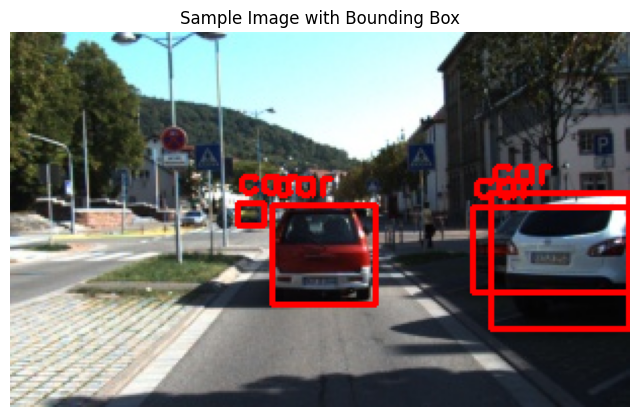

In [ ]:

# Paths (update if needed)
img_dir = os.path.join(base_dir,'images/train')
label_dir = os.path.join(base_dir,'labels/train')

# Get a sample image and label file
img_name = 'train_0012.jpg'
print(img_name)
img_path = os.path.join(img_dir, img_name)
label_path = os.path.join(label_dir, os.path.splitext(img_name)[0] + '.txt')

# Load image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w, _ = img.shape

# Draw bounding boxes
if os.path.exists(label_path):
    with open(label_path, 'r') as f:
        for line in f:
            class_id, x_center, y_center, box_w, box_h = map(float, line.strip().split())
            # Convert YOLO format to pixel coordinates
            x1 = int((x_center - box_w / 2) * w)
            y1 = int((y_center - box_h / 2) * h)
            x2 = int((x_center + box_w / 2) * w)
            y2 = int((y_center + box_h / 2) * h)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(img, 'car', (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

# Show image
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')
plt.title("Sample Image with Bounding Box")
plt.show()


In [ ]:
store_path = F"drive/MyDrive/perception project" #adapt to your file location
base_dir = os.path.join(store_path,'yolo_dataset')
results = model.train(data=os.path.join(base_dir, 'dataset.yaml'), epochs=100, imgsz=640)

Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=drive/MyDrive/perception project/yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=drive/MyDrive/perception project/yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train32, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True

train: Scanning /content/drive/MyDrive/perception project/yolo_dataset/labels/train.cache... 2969 images, 434 backgrounds, 0 corrupt: 100%|██████████| 2969/2969 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 4.1±4.8 ms, read: 7.2±8.6 MB/s, size: 31.9 KB)


val: Scanning /content/drive/MyDrive/perception project/yolo_dataset/labels/val.cache... 743 images, 104 backgrounds, 0 corrupt: 100%|██████████| 743/743 [00:00<?, ?it/s]


Plotting labels to runs/detect/train32/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train32
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.34G      1.104      1.006      1.072         56        640: 100%|██████████| 186/186 [01:19<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.88it/s]


                   all        743       2538      0.822      0.682      0.787      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.45G      1.191     0.9954      1.136         39        640: 100%|██████████| 186/186 [00:59<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.23it/s]


                   all        743       2538      0.803      0.725      0.806      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.45G       1.19     0.9292      1.132         39        640: 100%|██████████| 186/186 [00:58<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.21it/s]


                   all        743       2538      0.837      0.682      0.804      0.517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.45G       1.16     0.8715      1.122         40        640: 100%|██████████| 186/186 [00:59<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.19it/s]

                   all        743       2538      0.854      0.744      0.846      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.45G      1.123     0.8178      1.105         62        640: 100%|██████████| 186/186 [00:58<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.19it/s]

                   all        743       2538      0.876      0.789      0.883      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.46G      1.103     0.7949      1.093         35        640: 100%|██████████| 186/186 [01:00<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.09it/s]


                   all        743       2538       0.86      0.805      0.887      0.649

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.46G      1.079      0.768      1.081         64        640: 100%|██████████| 186/186 [01:00<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.22it/s]

                   all        743       2538       0.87      0.771      0.864      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.46G      1.054     0.7478      1.068         45        640: 100%|██████████| 186/186 [00:58<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.30it/s]

                   all        743       2538       0.89      0.811      0.902      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.46G      1.027     0.7198      1.057         42        640: 100%|██████████| 186/186 [00:58<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.13it/s]

                   all        743       2538      0.899      0.822      0.906      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.46G      1.021     0.7112      1.056         62        640: 100%|██████████| 186/186 [01:00<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.13it/s]

                   all        743       2538       0.89      0.807      0.898      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.46G      1.007     0.6936      1.054         60        640: 100%|██████████| 186/186 [00:58<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.28it/s]

                   all        743       2538      0.906      0.825      0.913      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.46G     0.9905     0.6884      1.042         63        640: 100%|██████████| 186/186 [00:58<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.38it/s]

                   all        743       2538      0.898      0.837      0.918      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.46G     0.9777      0.672      1.035         53        640: 100%|██████████| 186/186 [00:57<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.34it/s]

                   all        743       2538      0.899      0.836       0.92      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.46G     0.9598     0.6613      1.029         51        640: 100%|██████████| 186/186 [00:58<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.01it/s]

                   all        743       2538      0.914      0.847      0.925      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.46G     0.9621     0.6568      1.031         67        640: 100%|██████████| 186/186 [00:58<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.07it/s]

                   all        743       2538      0.919      0.831      0.923      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.46G     0.9436     0.6416      1.018         69        640: 100%|██████████| 186/186 [00:58<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.26it/s]

                   all        743       2538      0.915      0.836      0.926      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.46G     0.9439     0.6389      1.023         51        640: 100%|██████████| 186/186 [00:58<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.90it/s]

                   all        743       2538      0.912      0.853      0.931       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.46G     0.9258     0.6219      1.014         51        640: 100%|██████████| 186/186 [00:58<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.33it/s]

                   all        743       2538       0.91      0.854      0.932      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.46G     0.9143     0.6078      1.006         71        640: 100%|██████████| 186/186 [00:57<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.45it/s]

                   all        743       2538      0.917      0.855      0.934      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.46G       0.91     0.6081      1.008         53        640: 100%|██████████| 186/186 [00:58<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.37it/s]

                   all        743       2538      0.911      0.863      0.938      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.46G     0.8991     0.6045          1         58        640: 100%|██████████| 186/186 [00:59<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.82it/s]

                   all        743       2538      0.926      0.851      0.934      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.46G     0.9011     0.6042      1.002         56        640: 100%|██████████| 186/186 [00:57<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.31it/s]

                   all        743       2538      0.929      0.852       0.94      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.46G     0.8877     0.5872     0.9919         51        640: 100%|██████████| 186/186 [00:58<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.34it/s]

                   all        743       2538      0.927      0.865      0.938      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.46G     0.8798      0.584     0.9931         42        640: 100%|██████████| 186/186 [00:57<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.32it/s]

                   all        743       2538      0.925      0.879      0.944      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.46G     0.8728     0.5772     0.9876         73        640: 100%|██████████| 186/186 [00:57<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.52it/s]

                   all        743       2538       0.93      0.872      0.943      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.46G     0.8745     0.5769     0.9905         52        640: 100%|██████████| 186/186 [00:58<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.68it/s]

                   all        743       2538      0.922      0.875      0.943      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.46G     0.8673     0.5736     0.9857         54        640: 100%|██████████| 186/186 [00:57<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.57it/s]


                   all        743       2538       0.92      0.878      0.945      0.745

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.46G     0.8529     0.5634      0.978         61        640: 100%|██████████| 186/186 [00:59<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.25it/s]

                   all        743       2538      0.919      0.889      0.948      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.46G     0.8527     0.5561      0.978         73        640: 100%|██████████| 186/186 [00:59<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.69it/s]

                   all        743       2538      0.929      0.869      0.945      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.46G     0.8459     0.5551     0.9738         41        640: 100%|██████████| 186/186 [00:59<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.25it/s]

                   all        743       2538      0.934      0.881      0.949      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.46G      0.835     0.5486     0.9745        100        640: 100%|██████████| 186/186 [00:58<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.28it/s]

                   all        743       2538       0.93      0.883      0.952       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.46G      0.838     0.5449     0.9704         48        640: 100%|██████████| 186/186 [00:59<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.86it/s]

                   all        743       2538      0.928      0.891      0.949       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.46G     0.8346     0.5458     0.9758         37        640: 100%|██████████| 186/186 [00:58<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.59it/s]


                   all        743       2538      0.935      0.883      0.952      0.762

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.46G     0.8227     0.5402     0.9723         57        640: 100%|██████████| 186/186 [00:58<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.26it/s]

                   all        743       2538      0.951      0.874      0.951      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.46G     0.8131     0.5299      0.961         41        640: 100%|██████████| 186/186 [00:59<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.25it/s]

                   all        743       2538      0.943      0.878      0.953       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.46G     0.8163     0.5344     0.9615         66        640: 100%|██████████| 186/186 [00:58<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.45it/s]

                   all        743       2538      0.945      0.881      0.955       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.46G     0.7992     0.5251      0.956         80        640: 100%|██████████| 186/186 [00:58<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.07it/s]

                   all        743       2538      0.943      0.871      0.949      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.46G     0.8108     0.5297     0.9647         73        640: 100%|██████████| 186/186 [01:00<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  4.00it/s]

                   all        743       2538      0.924      0.891      0.952      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.46G     0.7962     0.5176     0.9582         74        640: 100%|██████████| 186/186 [00:58<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.37it/s]

                   all        743       2538      0.944      0.895      0.958      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.46G     0.8026     0.5188      0.959         38        640: 100%|██████████| 186/186 [00:58<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.21it/s]

                   all        743       2538      0.935      0.895      0.954      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.46G     0.7945     0.5139     0.9591         38        640: 100%|██████████| 186/186 [00:58<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.48it/s]

                   all        743       2538      0.937      0.886      0.953      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.46G     0.7933     0.5146     0.9588         60        640: 100%|██████████| 186/186 [00:58<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.34it/s]

                   all        743       2538      0.937      0.895      0.958       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.46G     0.7766     0.5049     0.9528         53        640: 100%|██████████| 186/186 [00:57<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.24it/s]

                   all        743       2538      0.941      0.898      0.958      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.46G     0.7726     0.5042     0.9479         46        640: 100%|██████████| 186/186 [00:58<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.37it/s]

                   all        743       2538      0.948       0.89      0.961      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.46G     0.7753     0.5037     0.9476         46        640: 100%|██████████| 186/186 [00:57<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.78it/s]


                   all        743       2538      0.946      0.896      0.958      0.783

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.46G     0.7639     0.4976      0.945         70        640: 100%|██████████| 186/186 [00:57<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.94it/s]

                   all        743       2538      0.934      0.907      0.961       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.46G     0.7623     0.4927     0.9435         44        640: 100%|██████████| 186/186 [00:58<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.39it/s]

                   all        743       2538       0.94      0.897      0.962      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.46G     0.7588     0.4914     0.9395         92        640: 100%|██████████| 186/186 [00:57<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.20it/s]

                   all        743       2538       0.94      0.902      0.961      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.46G     0.7571      0.491     0.9414         42        640: 100%|██████████| 186/186 [00:57<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.43it/s]

                   all        743       2538      0.937        0.9      0.958      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.46G      0.751     0.4853     0.9356         56        640: 100%|██████████| 186/186 [00:57<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.82it/s]

                   all        743       2538      0.931      0.911      0.962      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.46G     0.7537      0.483     0.9381         32        640: 100%|██████████| 186/186 [00:58<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.37it/s]

                   all        743       2538       0.94      0.904      0.962      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.46G      0.738     0.4788     0.9373         55        640: 100%|██████████| 186/186 [00:57<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.37it/s]

                   all        743       2538      0.946        0.9      0.961      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.46G     0.7371     0.4772     0.9345         97        640: 100%|██████████| 186/186 [00:59<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.23it/s]

                   all        743       2538       0.95      0.901      0.963      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.46G     0.7347     0.4702     0.9343         39        640: 100%|██████████| 186/186 [01:00<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.25it/s]

                   all        743       2538      0.943      0.904      0.963      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.46G     0.7352     0.4752     0.9314         50        640: 100%|██████████| 186/186 [00:59<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.29it/s]

                   all        743       2538      0.938      0.912      0.966      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.46G     0.7239     0.4696     0.9283         46        640: 100%|██████████| 186/186 [00:59<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.94it/s]


                   all        743       2538      0.947      0.906      0.965      0.798

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.46G     0.7172     0.4595     0.9273         32        640: 100%|██████████| 186/186 [00:58<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.35it/s]

                   all        743       2538      0.946      0.914      0.967      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.46G     0.7251     0.4626     0.9325         56        640: 100%|██████████| 186/186 [00:57<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]

                   all        743       2538      0.952      0.906      0.966      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.46G     0.7144     0.4592     0.9257         40        640: 100%|██████████| 186/186 [00:57<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.21it/s]

                   all        743       2538      0.936      0.911      0.964      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.46G     0.7096     0.4587     0.9203         62        640: 100%|██████████| 186/186 [00:58<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.29it/s]

                   all        743       2538      0.953      0.907      0.967      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.46G     0.7063     0.4566      0.922         79        640: 100%|██████████| 186/186 [00:57<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.21it/s]

                   all        743       2538      0.954      0.907      0.966      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.46G     0.7042     0.4548     0.9186         70        640: 100%|██████████| 186/186 [00:57<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.82it/s]

                   all        743       2538      0.939      0.918      0.967      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.46G     0.7013     0.4502     0.9195         21        640: 100%|██████████| 186/186 [00:57<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.59it/s]

                   all        743       2538      0.946      0.909      0.968      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.46G     0.6915     0.4479      0.917         45        640: 100%|██████████| 186/186 [00:58<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.25it/s]

                   all        743       2538      0.952      0.913      0.969      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.46G     0.6953     0.4458     0.9189         70        640: 100%|██████████| 186/186 [00:58<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.28it/s]

                   all        743       2538      0.949       0.91      0.967      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.46G     0.6943     0.4444     0.9194         56        640: 100%|██████████| 186/186 [00:59<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.84it/s]

                   all        743       2538      0.961      0.901      0.968      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.46G     0.6842     0.4389     0.9134         45        640: 100%|██████████| 186/186 [00:59<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.20it/s]

                   all        743       2538      0.954       0.91      0.969      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.46G     0.6846     0.4404     0.9128         61        640: 100%|██████████| 186/186 [01:00<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.48it/s]

                   all        743       2538      0.958      0.903      0.968      0.818



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.46G      0.686     0.4385     0.9152         59        640: 100%|██████████| 186/186 [00:58<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.32it/s]

                   all        743       2538      0.943       0.92      0.969      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.46G     0.6734     0.4314     0.9081         57        640: 100%|██████████| 186/186 [00:58<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.30it/s]

                   all        743       2538      0.957      0.911       0.97       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.46G     0.6669     0.4303     0.9098         55        640: 100%|██████████| 186/186 [01:00<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.83it/s]

                   all        743       2538      0.949      0.915      0.971      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.46G     0.6757     0.4322     0.9107         28        640: 100%|██████████| 186/186 [00:58<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]

                   all        743       2538      0.954      0.915      0.971       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.46G     0.6713     0.4302     0.9107         48        640: 100%|██████████| 186/186 [00:59<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.24it/s]

                   all        743       2538      0.949       0.92      0.972      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.46G       0.66     0.4251     0.9044         87        640: 100%|██████████| 186/186 [01:00<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.67it/s]

                   all        743       2538      0.951      0.923      0.971      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.46G     0.6513     0.4186     0.9037         49        640: 100%|██████████| 186/186 [00:59<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.15it/s]

                   all        743       2538      0.962      0.913      0.971      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.46G     0.6613      0.424     0.9052         38        640: 100%|██████████| 186/186 [00:59<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.49it/s]

                   all        743       2538      0.951      0.927      0.972      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.46G     0.6522     0.4158     0.9021         78        640: 100%|██████████| 186/186 [01:00<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.23it/s]

                   all        743       2538      0.963      0.913      0.971      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.46G     0.6509     0.4176     0.9037         51        640: 100%|██████████| 186/186 [00:59<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.57it/s]

                   all        743       2538      0.949      0.926      0.972      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.46G      0.653     0.4184     0.9018         48        640: 100%|██████████| 186/186 [00:59<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.29it/s]

                   all        743       2538      0.953      0.924      0.973       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.46G     0.6358     0.4096     0.9012         47        640: 100%|██████████| 186/186 [00:59<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.25it/s]

                   all        743       2538      0.953      0.929      0.973       0.83



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.46G     0.6379     0.4108      0.898         71        640: 100%|██████████| 186/186 [01:00<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.24it/s]

                   all        743       2538      0.955      0.929      0.973      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.46G     0.6343     0.4079     0.8949         75        640: 100%|██████████| 186/186 [00:59<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.28it/s]

                   all        743       2538      0.965      0.915      0.973      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.46G     0.6342     0.4057     0.8968         61        640: 100%|██████████| 186/186 [00:59<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.87it/s]

                   all        743       2538       0.96      0.924      0.973      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.46G     0.6252     0.4002     0.8946         35        640: 100%|██████████| 186/186 [00:59<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.16it/s]

                   all        743       2538      0.956      0.927      0.975      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.46G     0.6271     0.4014     0.8927         59        640: 100%|██████████| 186/186 [00:59<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.33it/s]

                   all        743       2538      0.959      0.926      0.974      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.47G     0.6256     0.4017     0.8939         83        640: 100%|██████████| 186/186 [00:59<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.46it/s]

                   all        743       2538      0.957      0.923      0.974      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.47G     0.6208     0.3964     0.8917         84        640: 100%|██████████| 186/186 [00:59<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.28it/s]

                   all        743       2538      0.957      0.925      0.973      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.47G     0.6136     0.3949     0.8898         46        640: 100%|██████████| 186/186 [00:59<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]

                   all        743       2538      0.951      0.933      0.974      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.47G     0.6167     0.3939     0.8901         91        640: 100%|██████████| 186/186 [00:59<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.36it/s]

                   all        743       2538      0.945      0.938      0.974      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.47G      0.609     0.3897     0.8873         42        640: 100%|██████████| 186/186 [00:58<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.25it/s]

                   all        743       2538      0.955      0.934      0.976      0.838


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.47G     0.5886     0.3619     0.8726         23        640: 100%|██████████| 186/186 [00:58<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.54it/s]

                   all        743       2538      0.962      0.924      0.974      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.47G     0.5696     0.3522     0.8717         27        640: 100%|██████████| 186/186 [00:56<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.21it/s]

                   all        743       2538      0.962      0.925      0.974      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.47G     0.5624     0.3468     0.8683         20        640: 100%|██████████| 186/186 [00:55<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.38it/s]

                   all        743       2538      0.967      0.919      0.975      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.47G     0.5486     0.3429     0.8661         15        640: 100%|██████████| 186/186 [00:56<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.31it/s]

                   all        743       2538      0.964      0.921      0.975      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.47G     0.5486      0.341     0.8634         16        640: 100%|██████████| 186/186 [00:56<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.35it/s]

                   all        743       2538      0.966      0.922      0.975       0.84



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.47G     0.5499     0.3386     0.8622         30        640: 100%|██████████| 186/186 [00:56<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.32it/s]

                   all        743       2538      0.962      0.925      0.974      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.47G     0.5426     0.3371     0.8597         18        640: 100%|██████████| 186/186 [00:57<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.39it/s]

                   all        743       2538      0.961      0.926      0.975      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.47G     0.5377     0.3336     0.8594         22        640: 100%|██████████| 186/186 [00:57<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.26it/s]

                   all        743       2538      0.966      0.923      0.976      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.47G     0.5347      0.334      0.858         37        640: 100%|██████████| 186/186 [00:56<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:07<00:00,  3.31it/s]

                   all        743       2538      0.966      0.928      0.976      0.842



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.47G     0.5392     0.3349     0.8619         17        640: 100%|██████████| 186/186 [00:56<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.12it/s]

                   all        743       2538      0.961      0.928      0.975      0.843



100 epochs completed in 1.826 hours.
Optimizer stripped from runs/detect/train32/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train32/weights/best.pt, 5.5MB

Validating runs/detect/train32/weights/best.pt...
Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:08<00:00,  2.78it/s]


                   all        743       2538      0.961      0.928      0.975      0.843
Speed: 0.1ms preprocess, 2.0ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/train32


Convert the test set into yolo format

In [ ]:
import numpy as np
import os
import cv2
from tqdm import tqdm

# === Load data ===
test_path = os.path.join(store_path, 'x_test.npy')  # Path to test data
test_data = np.load(test_path)

# === Output folders ===
base_dir = os.path.join(store_path, 'yolo_dataset')
test_dir = os.path.join(base_dir, 'images/test')
os.makedirs(test_dir, exist_ok=True)

# === Save images ===
def save_images(images, save_dir, prefix):
    for i, img in enumerate(tqdm(images, desc=f"Saving {prefix} images")):
        img_uint8 = (img * 255).astype(np.uint8)  # Convert to uint8 (0-255)
        img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV
        img_name = f"{prefix}_{i:04d}.jpg"  # Name format: test_0000.jpg, test_0001.jpg, etc.
        cv2.imwrite(os.path.join(save_dir, img_name), img_bgr)

# Save test images
save_images(test_data, test_dir, 'test')

Saving test images: 100%|██████████| 3769/3769 [00:30<00:00, 123.94it/s]


Predicting on the test set and generating the npy file

In [ ]:
from ultralytics import YOLO
import os
import numpy as np
from pathlib import Path


store_path = F"drive/MyDrive/perception project" #adapt to your file location
# Load the trained model from Google Drive (update this path after uploading)
model_path = os.path.join(store_path, 'results/best.pt')  # Replace with your uploaded model path (e.g., 'runs/train_exp/weights/best.pt')
model = YOLO(model_path)

# Define paths
base_dir = os.path.join(store_path, 'yolo_dataset')
test_dir = os.path.join(base_dir, 'images/test')

# Get list of test images
test_images = sorted([f for f in os.listdir(test_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
print(f"Found {len(test_images)} test images in {test_dir}")

# Run inference on test images
predictions = []
i=0
for img_name in test_images:
    i=i+1
    img_path = os.path.join(test_dir, img_name)
    # Predict with confidence threshold and image size matching training
    results = model.predict(img_path, conf=0.5, imgsz=640, device=0, verbose=False)
    print(f"\rSaving image: {img_name} ({i+1}/{len(test_images)})", end='')
    # Extract predictions
    if len(results) == 0:
        print(f"No detections for {img_name}")
        predictions.append({'boxes': np.array([]).reshape(0, 4), 'classes': np.array([]), 'scores': np.array([])})
        continue

    result = results[0]  # Results for one image
    # Get boxes in [xmin, ymin, xmax, ymax] format
    boxes = result.boxes.xyxy.cpu().numpy().astype(np.int64)  # Shape: (N, 4)
    # Get class labels
    classes = result.boxes.cls.cpu().numpy()  # Shape: (N,)
    # Get confidence scores
    scores = result.boxes.conf.cpu().numpy()  # Shape: (N,)

    # Create prediction dictionary
    pred_dict = {
        'boxes': boxes,
        'classes': classes,
        'scores': scores
    }
    predictions.append(pred_dict)

# Convert predictions to NumPy array with object dtype
y_pred = np.array(predictions, dtype=object)

# Save to y_pred.npy
output_path = os.path.join(store_path, 'results/y_pred.npy')
np.save(output_path, y_pred)
print(f"Saved predictions to {output_path}")

# Verify the saved file
loaded_preds = np.load(output_path, allow_pickle=True)
print(f"Shape of y_pred.npy: {loaded_preds.shape}")
print(f"First prediction: {loaded_preds[0]}")

Found 3769 test images in drive/MyDrive/perception project/yolo_dataset/images/test
Saving image: test_3768.jpg (3770/3769)Saved predictions to drive/MyDrive/perception project/results/y_pred.npy
Shape of y_pred.npy: (3769,)
First prediction: {'boxes': array([[ 41,  90,  58, 100]]), 'classes': array([          0], dtype=float32), 'scores': array([    0.85436], dtype=float32)}


Testing with images

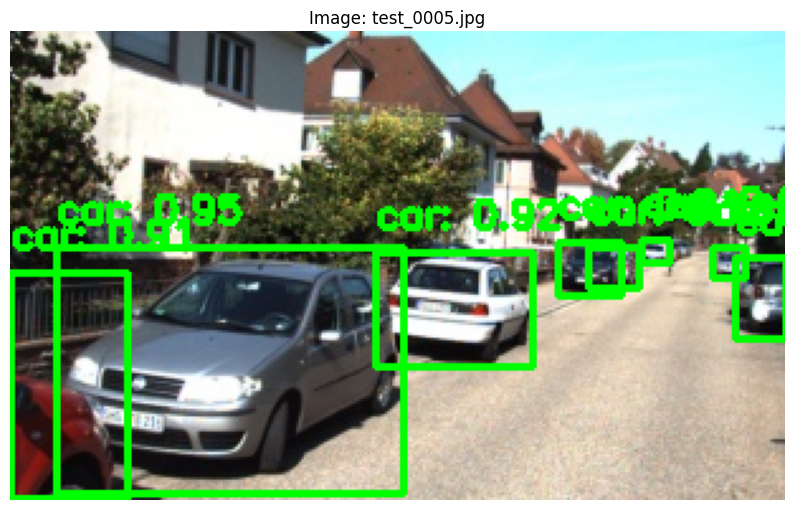

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os


# Define paths
base_dir = os.path.join(store_path, 'yolo_dataset')
test_dir = os.path.join(base_dir, 'images/test')
y_pred_path = os.path.join(store_path, 'results/y_pred.npy')

# Load predictions
y_pred = np.load(y_pred_path, allow_pickle=True)

# Choose an image index to visualize (change this to view different images)
image_index = 5  # For test_0000.jpg; change to 1 for test_0001.jpg, etc.

# Load the corresponding image
img_name = f"test_{image_index:04d}.jpg"
img_path = os.path.join(test_dir, img_name)
if not os.path.exists(img_path):
    raise FileNotFoundError(f"Image not found: {img_path}")
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib

# Get predictions for this image
pred = y_pred[image_index]
boxes = pred['boxes']  # Shape: (N, 4) in [xmin, ymin, xmax, ymax]
classes = pred['classes']  # Shape: (N,)
scores = pred['scores']  # Shape: (N,)

# Draw bounding boxes on the image
for box, cls, score in zip(boxes, classes, scores):
    if len(box) == 0:  # Skip if no detections
        continue
    xmin, ymin, xmax, ymax = box
    # Draw rectangle
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    # Add label with class and score
    label = f"car: {score:.2f}"  # Assuming class 0 is 'car'
    cv2.putText(img, label, (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display the image
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.title(f"Image: {img_name}")
plt.show()